In [19]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'kernel_regression_metric'
seed = 42

In [20]:
import numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/kernel_regression_metric'
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt
import functools
import domain_adapt.domain_adapt.KR_metric as KR_metric
import data.mushroom.mushroom.fxns as uci_data
import domain_adapt.domain_adapt.data_fxns as data_fxns

(250, 6) (60, 6)


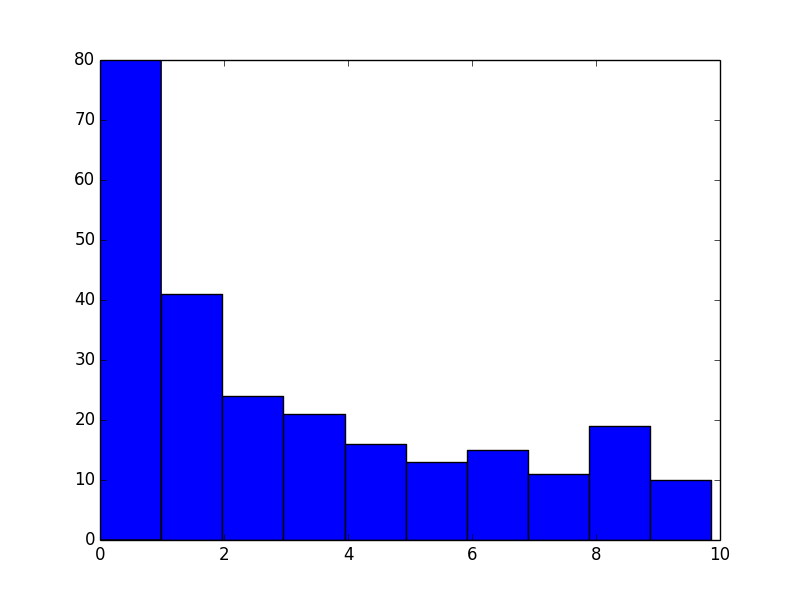

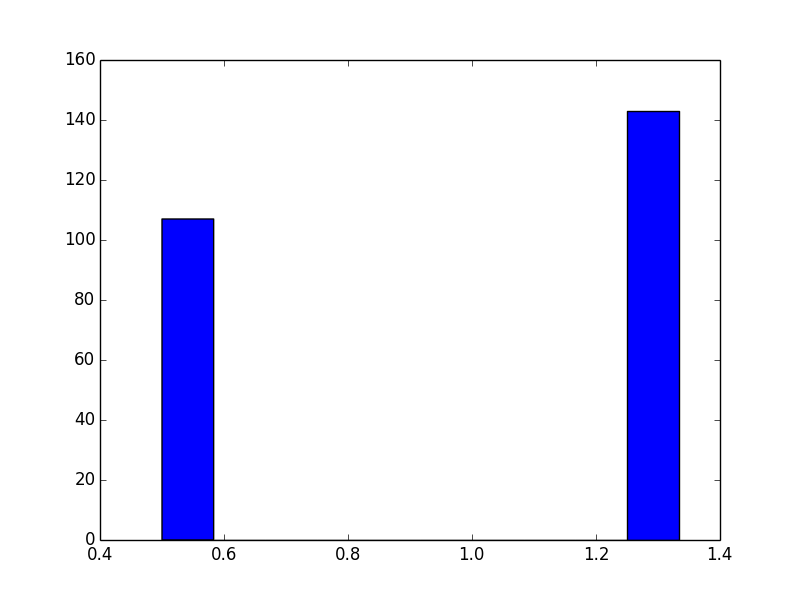

In [41]:
# get data
xs, ys, ws, xs_test, ys_test = data_fxns.fig_2_train_test_data(250, 60, 0.6, 0.8, 3)
#xs, ys, ws, xs_test, ys_test = data_fxns.split_whitewine_data()
print xs.shape, xs_test.shape
N, x_dim = xs.shape
fig,ax = plt.subplots()
ax.hist(ys)
basic.display_fig_inline(fig)
fig,ax = plt.subplots()
ax.hist(ws)
basic.display_fig_inline(fig)

* simulate data.  generate p(x) = p(x[0:3]) * p([x[3:10]).  specify, compute f(x).  then apply T().  dim reduct should hopefully recover first 3 rows of T_inv.

In [42]:
# get color for each point
colormap = plt.cm.get_cmap('Spectral')
colors = colormap(ys)

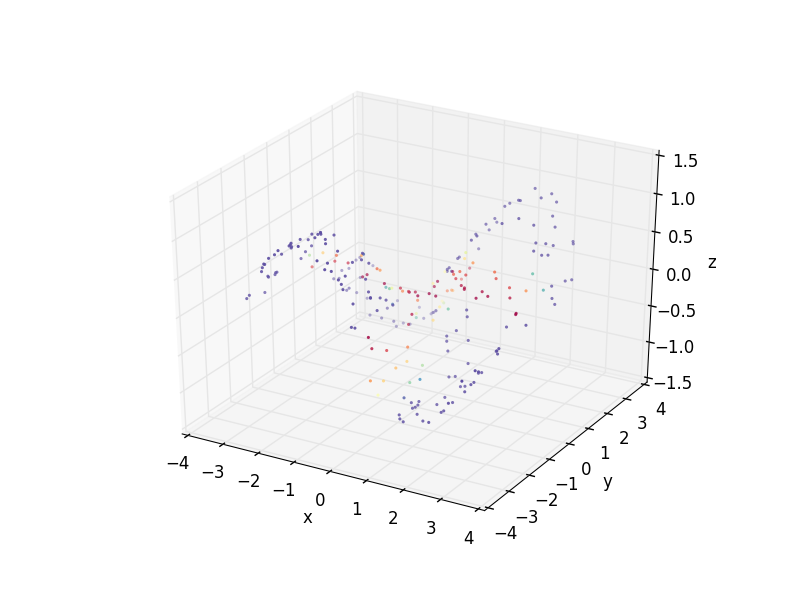

In [43]:
# plot data in x
from mpl_toolkits.mplot3d import Axes3D
try:
    basic.scatter_3d(xs[:,0],xs[:,1],xs[:,2], colors=colors)
except:
    basic.scatter(xs[:,0],xs[:,1],colors=colors)

In [25]:
# define rank of distance metric
D = 1

In [26]:
# define weights for debugging grad descent, which should just be 1's
ws_dummy = np.ones(N)

In [27]:
# define some utility functions for optimizing
real_shape = (D,x_dim)
mat_to_vec = lambda x: x.reshape(D*x_dim)
vec_to_mat = lambda x:x.reshape((D,x_dim))
mat_f = functools.partial(KR_metric.L,xs,ys,ws_dummy)
vec_f = lambda vec_A: mat_f(vec_to_mat(vec_A))
mat_f_grad = functools.partial(KR_metric.L_grad,xs,ys,ws_dummy)
vec_f_grad = lambda vec_A: mat_to_vec(mat_f_grad(vec_to_mat(vec_A)))

In [28]:
# setup opt
mat_A_0 = np.random.uniform(size=real_shape)
vec_A_0 = mat_to_vec(mat_A_0)
check = scipy.optimize.check_grad(vec_f, vec_f_grad, vec_A_0)
numpy_grad = scipy.optimize.approx_fprime(vec_A_0, vec_f, .01)
my_grad = vec_f_grad(vec_A_0)
print 'gradient check', check, numpy_grad-my_grad

gradient check 0.000101786816408 [-0.30042796 -0.01648168 -0.12841521 -0.01460729  0.15569019 -0.09121363
 -0.02967253 -0.03434441  0.02711868  0.23284228 -0.12412686]


In [29]:
# optimize using numpy
def print_stuff(x):
    print x, vec_f(x)
    return x
#optimizer = scipy.optimize.fmin_bfgs
#vec_solution = scipy.optimize.fmin(vec_f,vec_A_0,callback=print_stuff)
vec_solution = scipy.optimize.fmin_bfgs(vec_f,vec_A_0,vec_f_grad,callback=print_stuff)
fit_A = vec_to_mat(vec_solution)
print 'fit_A\n',fit_A
print 'K', np.exp(KR_metric.log_K_f(fit_A,xs))[0:5,0:5]
print 'eig of A\'A\n',np.linalg.eig(fit_A.T.dot(fit_A))

[-0.18971539 -0.11372165  0.21846066  0.82237887  1.08718753  1.33372618
  2.06639339  0.71784125 -0.69421163 -0.9058869   0.12493204] 514.00178774
[-0.2159401  -0.13045742  0.19177165  0.8282724   1.09943018  1.34270866
  2.11458132  0.72465221 -0.72460207 -0.89434988  0.10549673] 512.713301314
[-0.49807517 -0.41123012 -0.12834279  0.97648195  1.12675606  1.69264218
  2.64660798  0.79355105 -0.68557363 -0.68157092  0.07944748] 499.900240789
[-1.17592208 -0.70677129 -0.81373683  1.11366964  1.22133803  2.49766535
  3.7272879   0.81376985 -0.55536119 -0.26355833  0.00565917] 489.793376509
[-1.37261288 -0.77793728 -1.07679665  1.16765966  1.25984235  2.72222209
  4.05260218  0.8853518  -0.44806706 -0.18060692 -0.09764325] 485.114574679
[-1.63890497 -0.58908897 -1.24014172  1.47116835  1.1963045   3.03289304
  4.54181718  1.17382172 -0.39889647 -0.11196045 -0.12886715] 481.301925236
[-1.9453645  -0.42927328 -1.49255755  1.8112241   1.12094084  3.30772978
  4.79367237  1.38368004 -0.420179

In [30]:
# setup my optimizer
stop_f = lambda t, x, x_new: (t > 25) or (np.linalg.norm(x-x_new) < .001)
step_f = functools.partial(KR_metric.line_search,100,0.5,0.5,vec_f)

In [31]:
# optimize using mine
my_vec_solution = KR_metric.grad_descent(step_f,stop_f,vec_A_0,vec_f,vec_f_grad)
A_dummy = vec_to_mat(my_vec_solution)
print 'fit_A\n',A_dummy
print 'K', np.exp(KR_metric.log_K_f(A_dummy,xs))[0:5,0:5]
print 'eig of A\'A\n',np.linalg.eig(A_dummy.T.dot(A_dummy))

alpha, change 0.048828125 -16.6996729437
x,f(x) [-0.0035097   0.2119585   0.5435758   0.77759493  0.94778653  0.99844872
  1.38380163  0.78309147 -0.22533995 -0.21276652  0.17275779] 497.979256271
alpha, change 0.048828125 -7.48337200217
x,f(x) [-0.98288131  0.96098331  0.71942733  0.51402393  1.08270436  1.18384927
  1.59590471  0.6774789  -0.46746839  0.84172425 -0.35341225] 490.495884269
alpha, change 0.01220703125 -4.81276052529
x,f(x) [-1.07929638  0.78122575  0.56743309  0.60156062  1.12231586  1.18637072
  1.72468182  0.83742444 -0.18818411  0.68484379 -0.48818437] 485.683123744
alpha, change 0.0244140625 -6.36434538929
x,f(x) [-0.71494723  0.54659765  0.910353    0.76037394  1.09239385  1.15141234
  1.77859074  0.94659324 -0.64878923  0.66709143 -0.46698728] 479.318778354
alpha, change 0.1953125 -14.4813914645
x,f(x) [-4.42230798 -0.86676753  1.23281518 -0.08615652  1.19453205  2.92188113
  4.35710512 -2.31089767  3.38380447  1.14569929  4.6487577 ] 464.83738689
alpha, change 0

In [32]:
# define update step for alternating.  same for future alternatings    
short_stop_f = lambda t, x, x_new: (t > 1) or (np.linalg.norm(x-x_new) < .001)
short_grad_descent = functools.partial(KR_metric.grad_descent, step_f, short_stop_f)

short_update_A = functools.partial(KR_metric.update_A,mat_to_vec,vec_to_mat,\
                                   KR_metric.L,KR_metric.L_grad,short_grad_descent)

In [33]:
# get dummy test predictions
dummy_ys_test_hat = KR_metric.ys_hat_f_log_K_test(A_dummy, xs, ys, xs_test)

In [34]:
# print dummy error
print 'dummy test error', np.linalg.norm(dummy_ys_test_hat - ys_test, ord=2)**2

dummy test error 302.94292667


In [35]:
# define weight estimator for alternating
cheating_weight_f = lambda us_train, us_test: ws

In [36]:
# do alternating, with cheating weights
A_cheating = KR_metric.run(short_update_A, cheating_weight_f, mat_A_0, ws, xs, xs_test, ys)
print 'A_cheating', A_cheating

alpha, change 0.390625 -36.3444375214
x,f(x) [[-1.39984849  2.11019909 -3.74940157  1.28848176  5.24892203  2.14426189
   4.11419536  1.20246991 -6.760949   -5.86671515 -2.4996943 ]] 286.838908282
alpha, change 0.78125 -16.5442123186
x,f(x) [[ -2.4694469    6.29736057  -2.51671009  14.38668083   7.22744374
   -8.44299578  -0.45080951  10.1584679  -11.722406     3.45956663
   -3.93255722]] 326.639362025
alpha, change 0.048828125 -20.8279085191
x,f(x) [[ -2.24187697   7.48005191  -0.5112236   15.0301245    5.61118555
   -7.83953401   0.07494086  10.6827708  -11.50776333   3.96244623
   -3.72610086]] 301.348035495
[[ -2.4694469    6.29736057  -2.51671009  14.38668083   7.22744374
   -8.44299578  -0.45080951  10.1584679  -11.722406     3.45956663
   -3.93255722]]
alpha, change 0.048828125 -20.8279085191
x,f(x) [[ -2.24187697   7.48005191  -0.5112236   15.0301245    5.61118555
   -7.83953401   0.07494086  10.6827708  -11.50776333   3.96244623
   -3.72610086]] 301.348035495
alpha, change 0.0

In [37]:
# get cheating test predictions
cheating_ys_test_hat = KR_metric.ys_hat_f_log_K_test(A_cheating, xs, ys, xs_test)

In [38]:
# print cheating error
print 'cheating test error', np.linalg.norm(cheating_ys_test_hat - ys_test, ord=2)**2

cheating test error 316.525281401
